In [3]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

In [57]:
def model():
    
    with pyro.plate("means_plate", 4):
        means = pyro.sample('means', dist.Normal(torch.tensor(0.), torch.tensor(1.)))

    with pyro.plate("observed_data", 600):
        category = pyro.sample('category', dist.Categorical(torch.tensor([0.25, 0.25, 0.0002, 0.25])))
    
        bug = pyro.sample("bug", dist.Normal(means[category], 
                                           torch.tensor([0.1, 0.2, 0.3, 0.3])[category]))
    
    
    return category, bug

pyro.set_rng_seed(41)
with pyro.poutine.trace() as tr:
    pyro.condition(model, data= {'means': torch.tensor([-1, 0., 1, 2])})()

for key in tr.trace.nodes.keys():
    print(key)
    print(tr.trace.nodes[key]['value'])
    

assert 2 not in list(torch.tensor(tr.trace.nodes['category']['value']).numpy())

synthetic_data = {key: tr.trace.nodes[key]['value'] for key in tr.trace.nodes.keys() if key in ['category', 'bug']}


means_plate
tensor([0, 1, 2, 3])
means
tensor([-1.,  0.,  1.,  2.])
observed_data
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 16

/tmp/ipykernel_25333/4144195354.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  assert 2 not in list(torch.tensor(tr.trace.nodes['category']['value']).numpy())


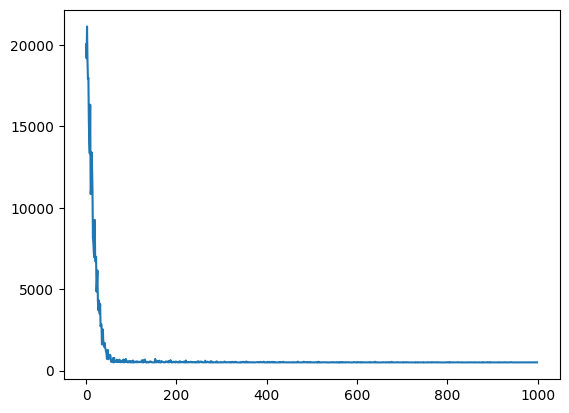

In [58]:
conditioned_model = pyro.condition(model, data=synthetic_data)

conditioned_model()

guide = pyro.infer.autoguide.AutoDiagonalNormal(conditioned_model)

#run svi inference
svi = pyro.infer.SVI(model=conditioned_model,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.03}),
                     loss=pyro.infer.Trace_ELBO())

#run inference
pyro.clear_param_store()
losses = []
for step in range(1000):
    losses.append(svi.step())

plt.plot(losses)




In [59]:
predictive = pyro.infer.Predictive(conditioned_model, guide=guide, num_samples=1000,)
samples = predictive()

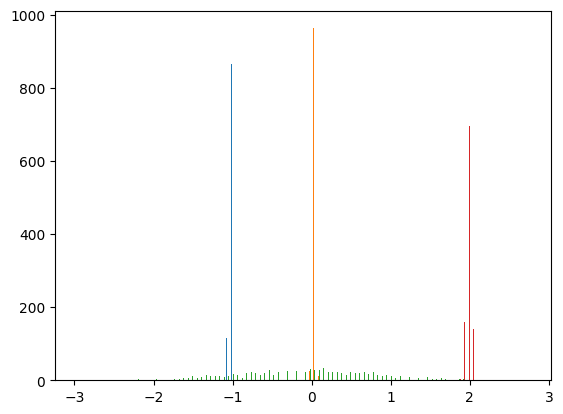

In [62]:
samples.keys()

plt.hist(samples['means'].numpy(), bins=100)
plt.show()